In [1]:
import numpy as np
import  matplotlib.pyplot as plt
from giae.se3.data import rand_matrix
import pandas as pd
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

In [2]:
import torch
from giae.se3.trainer import Trainer
from giae.se3.data import DataModule, TetrisDataset, TetrisDatasetPyG
from mpl_toolkits.mplot3d import Axes3D
from functools import partial

In [3]:
batch_size = 1024

In [4]:
dataset = partial(TetrisDatasetPyG,
                  rotate=True,
                  num_elements=10000,
                  noise_level=0.01,
                  translation_level=5.0)

In [5]:
datamodule = DataModule(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=4,
    num_eval_samples=200,
)
train_loader = iter(datamodule.train_dataloader(shuffle=False))

In [38]:
device = "cpu"
model = Trainer.load_from_checkpoint("tetris_se3/run0/last.ckpt", strict=False).to(device)
model = model.eval()
model.hparams

{'id': 1,
 'gpus': '1',
 'num_epochs': 100,
 'eval_freq': 250,
 'num_eval_samples': 200,
 'save_dir': 'Final_SE3_Tetris',
 'precision': 32,
 'progress_bar': True,
 'noise': 0.01,
 'translation': 5.0,
 'num_points': 200,
 'encoder_nearest': 16,
 'decoder_nearest': 16,
 'layer_norm': True,
 'batch_size': 512,
 'lr': 0.0001,
 'num_workers': 4,
 'resume_ckpt': '',
 'hidden_dim': 32,
 'num_layers': 5,
 'emb_dim': 2}

In [7]:
data = next(train_loader)

In [8]:
data

Batch(edge_index=[2, 12288], pos=[4096, 3], label=[1024, 8], rot=[1024, 3, 3], nelements=[1024], batch=[4096], ptr=[1025])

In [9]:
data.label.sum(0)

tensor([120., 129., 130., 128., 129., 145., 127., 116.])

In [10]:
pos_true = data.pos.view(batch_size, 4, 3)

In [11]:
labels = data.label.argmax(dim=-1)
idx = {l.item(): torch.where(labels==l)[0][0].item() for l in torch.unique(labels)}

In [12]:
idx

{0: 8, 1: 9, 2: 7, 3: 1, 4: 0, 5: 24, 6: 2, 7: 3}

## Iterate over `idx` to select the i-th shape

tensor([0., 0., 0., 0., 0., 0., 0., 1.])
MSE: 3.2435647881357e-05
MAE: 0.004351788200438023


<IPython.core.display.Javascript object>


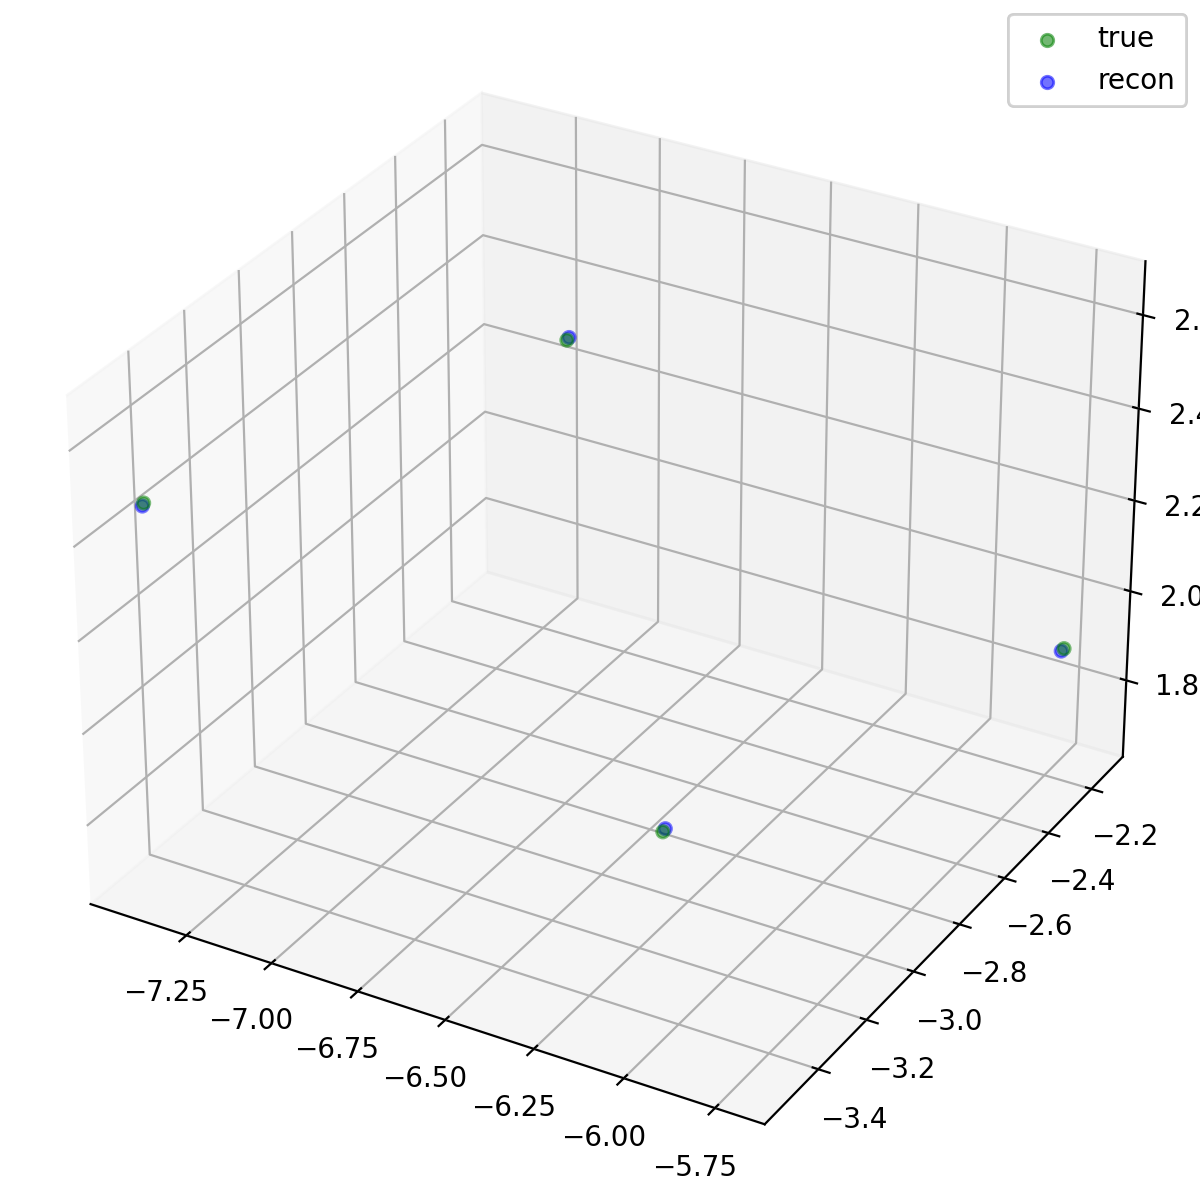

In [13]:
i = idx[7]
print(data.label[i])
with torch.no_grad():
    pos_gen, perm, _, rot_gen = model(data, hard=False)

pos_gen = pos_gen.view(batch_size, 4, 3)
pos_gen = pos_gen.squeeze()

print("MSE:", torch.mean(torch.pow(pos_gen-pos_true, 2)).item())
print("MAE:", torch.mean(torch.abs(pos_gen-pos_true)).item())

x, y, z = pos_true[i, :, 0], pos_true[i, :, 1], pos_true[i, :, 2]
xg, yg, zg = np.split(pos_gen[i].cpu().numpy(), 3 , -1)
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter(x, y, z, cmap='Greens', color="green", label="true", alpha=0.5)
ax.scatter(xg, yg, zg, cmap='Greens', color="blue", label="recon", alpha=0.5)

plt.legend()
plt.show()
fig.legend()

In [14]:
with torch.no_grad():
    shape_emb, point_emb, rot, transl, vout = model.model.encoder(pos=data.pos,
                                                                  batch=data.batch,
                                                                  batch_num_nodes=torch.bincount(data.batch),
                                                                  edge_index=data.edge_index,
                                                                  use_fc=False)

In [15]:
labels_l = ["Chiral_1", "Chiral_2", "Square", "Line", "Corner", "L", "T", "Zigzag"]

In [16]:
shape_emb.shape

torch.Size([1024, 2])

In [17]:
torch.bincount(data.label.argmax(-1))

tensor([120, 129, 130, 128, 129, 145, 127, 116])

In [18]:
dataframe = {r"emb_dim_1": shape_emb[:, 0].cpu().numpy(), r"emb_dim_2": shape_emb[:, 1].cpu().numpy(), "label_idx": data.label.argmax(-1).numpy()}

In [19]:
dataframe = pd.DataFrame(dataframe)

In [20]:
dataframe

,emb_dim_1,emb_dim_2,label_idx
0,-0.044716,-0.747446,4
1,0.445106,0.212380,3
2,0.376338,-0.564934,6
3,0.088809,-0.110914,7
4,0.380312,-0.563377,6
...,...,...,...
1019,-0.051453,-0.747157,4
1020,0.444777,0.214961,3
1021,-0.199842,-0.118271,2
1022,0.394020,-0.563403,6


In [21]:
dataframe['shape'] = dataframe['label_idx'].apply(lambda x: labels_l[x])

In [22]:
dataframe

,emb_dim_1,emb_dim_2,label_idx,shape
0,-0.044716,-0.747446,4,Corner
1,0.445106,0.212380,3,Line
2,0.376338,-0.564934,6,T
3,0.088809,-0.110914,7,Zigzag
4,0.380312,-0.563377,6,T
...,...,...,...,...
1019,-0.051453,-0.747157,4,Corner
1020,0.444777,0.214961,3,Line
1021,-0.199842,-0.118271,2,Square
1022,0.394020,-0.563403,6,T


In [23]:
import seaborn as sns
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [24]:
order = ['Zigzag', 'Square', 'Chiral_2', 'L', 'Chiral_1', 'Corner', 'T', 'Line']

In [25]:
my_palette = {i:k for i,k in zip(order, sns.color_palette())}

In [26]:
dataframe

,emb_dim_1,emb_dim_2,label_idx,shape
0,-0.044716,-0.747446,4,Corner
1,0.445106,0.212380,3,Line
2,0.376338,-0.564934,6,T
3,0.088809,-0.110914,7,Zigzag
4,0.380312,-0.563377,6,T
...,...,...,...,...
1019,-0.051453,-0.747157,4,Corner
1020,0.444777,0.214961,3,Line
1021,-0.199842,-0.118271,2,Square
1022,0.394020,-0.563403,6,T


<IPython.core.display.Javascript object>


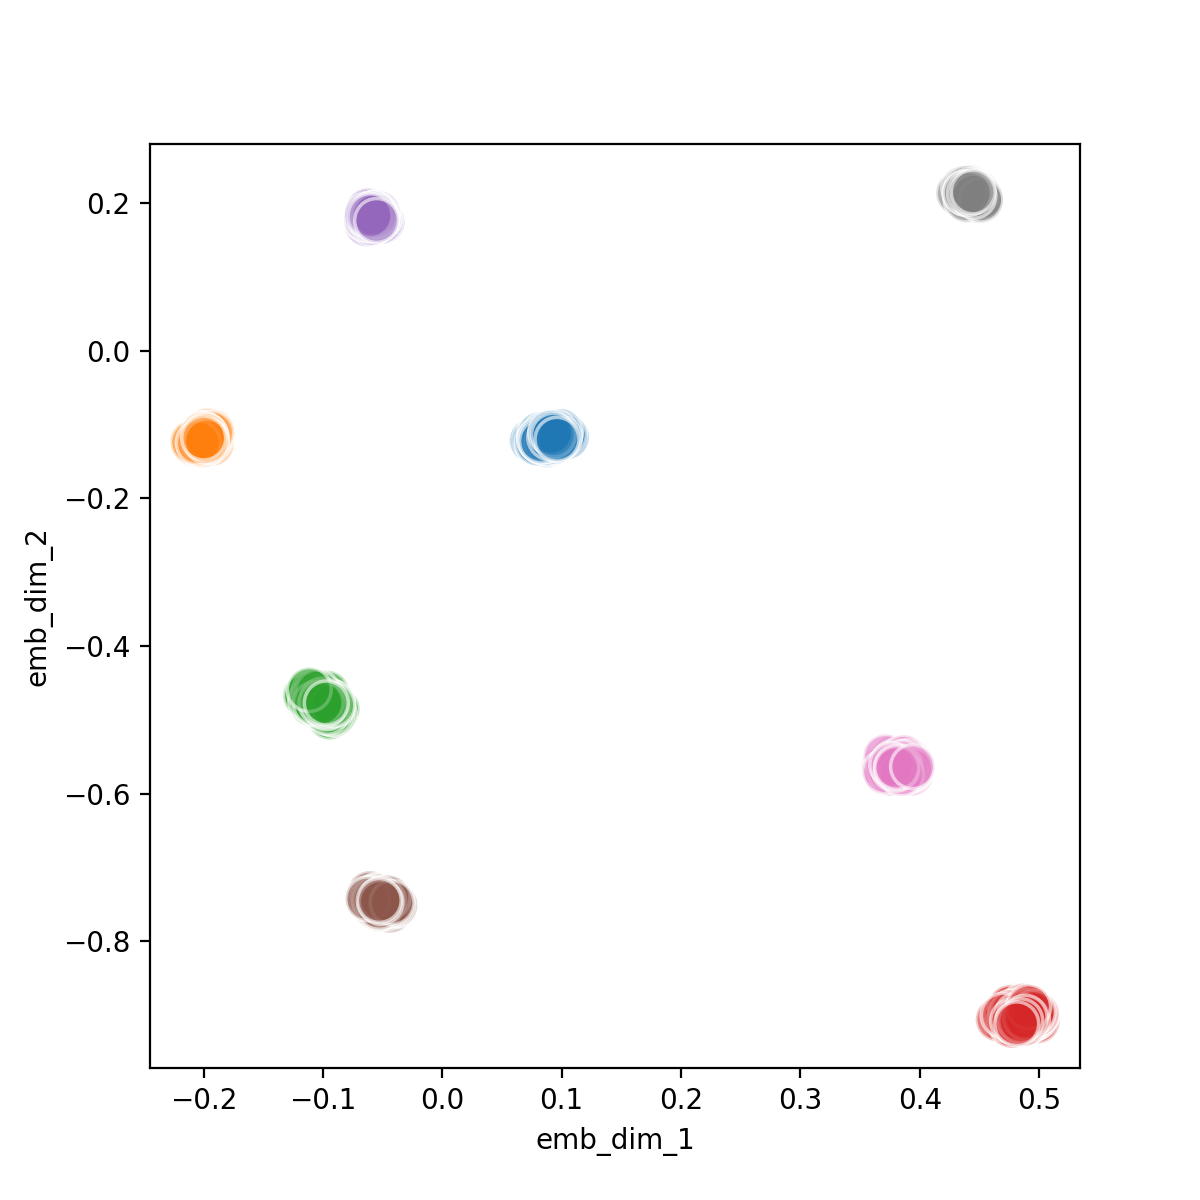

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))

g = sns.scatterplot(data=dataframe, x=r"emb_dim_1", y=r"emb_dim_2", hue="shape", 
                    alpha=0.6, palette=my_palette, s=250)

ax.get_legend().remove()
plt.savefig('2d_inv_embeddings.pdf', format='pdf')
plt.show()

## Checking for invariance and equivariance


Next, we check if the SE(3)-equivariant encoder network respects the constraints mentioned in the paper about rotation equivariance for the (3-1)=2  *learned* vector features to construct the rotation matrix (**but** is invariant to arbitrary translation), **and** the other constraint that the remaining *learned* 1 vector feature to be used as displacement vector, is indeed rotation **and** translation equivariant.

The `shape_emb` should be invariant to any rigid transformation.


In [28]:
dataset = partial(TetrisDatasetPyG,
                  rotate=True,
                  num_elements=10000,
                  noise_level=0.01,
                  translation_level=5.0)

In [29]:
datamodule = DataModule(
    dataset=dataset,
    batch_size=32,
    num_workers=4,
    num_eval_samples=200,
)
train_loader = iter(datamodule.train_dataloader(shuffle=False))

In [30]:
from scipy.spatial.transform import Rotation
R = torch.from_numpy(Rotation.random().as_matrix()).float().to(model.device)

In [31]:
EPS=1e-3


#### Check 1
We apply a rotation matrix on the point-cloud and check if the predicted group actions, i.e. the 2 vector-features, and 1 displacement vector are indeed rotationally equivariant.


In [32]:
data = next(train_loader)

In [33]:
shape_emb, point_emb, rot, transl, vout = model.model.encoder(pos=data.pos,
                                                              batch=data.batch,
                                                              batch_num_nodes=torch.bincount(data.batch),
                                                              edge_index=data.edge_index,
                                                              use_fc=False)

pos_R = data.pos @ R.T

shape_emb_R, point_emb_R, rot_R, transl_R, vout_R = model.model.encoder(pos=pos_R,
                                                                        batch=data.batch,
                                                                        batch_num_nodes=torch.bincount(data.batch),
                                                                        edge_index=data.edge_index,
                                                                        use_fc=False)



In [34]:
# Equivariance wrt to rotations
# shape embedding should be invariant wrt. rotation
assert torch.allclose(shape_emb, shape_emb_R, atol=EPS)
# equivariance for translation vector wrt. to rotation
assert torch.allclose(transl @ R.T, transl_R, atol=EPS)
# equivariance for rotation vectors wrt. to rotation
assert torch.allclose(vout @ R.T, vout_R, atol=EPS)
d = R @ rot - rot_R
assert d.norm().item() < EPS
assert torch.allclose(transl @ R.T, transl_R, atol=EPS)
# equivariance for rotation vectors wrt. to rotation
assert torch.allclose(vout @ R.T, vout_R, atol=EPS)
d = R @ rot - rot_R
assert d.norm().item() < EPS


#### Check 2
We apply a translation on the point-cloud and check if the predicted group actions, i.e. the 2 vector-features, are invariant but the 1 displacement vector is equivariant to translation.

In [35]:
# Equivariance wrt to translation
shape_emb_transl, point_emb_transl, rot_transl, transl2, vout_transl = model.model.encoder(pos=data.pos + torch.ones_like(data.pos),
                                                                                           batch=data.batch,
                                                                                           batch_num_nodes=torch.bincount(data.batch),
                                                                                           edge_index=data.edge_index,
                                                                                           use_fc=False)

assert torch.allclose(shape_emb, shape_emb_transl, atol=EPS)
# equivariance for translation vector wrt. to translation
assert torch.allclose(transl + torch.ones_like(transl), transl2, atol=EPS)
# invariance for rotation vectors wrt. to translation
assert torch.allclose(vout, vout_transl, atol=EPS)

#### Check 3
We apply a rotation and translation on the point-cloud and check if the predicted group actions, i.e.,:

- The 2 vector-features, are equivariant to rotation but invariant to translation.
- The 1 displacement vector is equivariant to translation and equivariant to rotation.

In [36]:
# Equivariance wrt to rotation + translation
shape_emb_rot_transl, point_emb_rot_transl,\
rot_rot_transl, transl_rot_2, vout_rot_transl = model.model.encoder(pos=pos_R + torch.ones_like(data.pos),
                                                                    batch=data.batch,
                                                                    batch_num_nodes=torch.bincount(data.batch),
                                                                    edge_index=data.edge_index,
                                                                    use_fc=False)

assert torch.allclose(shape_emb, shape_emb_rot_transl, atol=EPS)
# equivariance for translation vector wrt. to translation
assert torch.allclose(transl @ R.T + torch.ones_like(transl), transl_rot_2, atol=EPS)
# equivariance for rotation vectors wrt. to rotation, but invariant wrt to translation
assert torch.allclose(vout @ R.T, vout_rot_transl, atol=EPS)